# Day 1: Performance Metrics - Sharpe, Sortino, Drawdown

## Week 12 - Backtesting & Validation

### 🎯 Learning Objectives
- Master the calculation and interpretation of key performance metrics
- Understand Sharpe, Sortino, Max Drawdown, and Calmar ratios
- Implement metrics from scratch and with real market data
- Know when to use each metric

### ⏱️ Time Allocation
- Theory review: 30 min
- Guided exercises: 90 min
- Practice problems: 60 min
- Interview prep: 30 min

---

**Author**: ML Quant Finance Mastery  
**Difficulty**: Intermediate  
**Prerequisites**: Week 1-11 foundations

## 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Download market data
print("📥 Downloading market data...")
tickers = ['SPY', 'QQQ', 'IWM', 'TLT', 'GLD']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} days of data")
print(f"📅 Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print("\n📊 Assets: SPY (S&P500), QQQ (Nasdaq), IWM (Small Cap), TLT (Bonds), GLD (Gold)")

📥 Downloading market data...
✅ Loaded 1255 days of data
📅 Date range: 2021-01-25 to 2026-01-22

📊 Assets: SPY (S&P500), QQQ (Nasdaq), IWM (Small Cap), TLT (Bonds), GLD (Gold)


## 2. Sharpe Ratio: Implementation from Scratch

### Mathematical Definition

$$SR = \frac{E[R - R_f]}{\sigma_R} \times \sqrt{252}$$

Where:
- $E[R - R_f]$ = Expected excess return
- $\sigma_R$ = Standard deviation of returns
- $\sqrt{252}$ = Annualization factor

In [2]:
def sharpe_ratio_scratch(returns, risk_free_rate=0.0):
    """
    Calculate Sharpe Ratio from scratch
    
    Step-by-step implementation
    """
    # Step 1: Calculate excess returns
    excess_returns = returns - risk_free_rate
    
    # Step 2: Calculate mean excess return
    mean_excess = np.mean(excess_returns)
    
    # Step 3: Calculate standard deviation
    std_return = np.std(returns, ddof=1)  # Sample std
    
    # Step 4: Calculate daily Sharpe
    daily_sharpe = mean_excess / std_return if std_return > 0 else 0
    
    # Step 5: Annualize
    annual_sharpe = daily_sharpe * np.sqrt(252)
    
    return annual_sharpe

# Calculate for each asset
print("📊 SHARPE RATIO CALCULATION")
print("=" * 50)
for ticker in returns.columns:
    sharpe = sharpe_ratio_scratch(returns[ticker].values)
    mean_ret = returns[ticker].mean() * 252
    vol = returns[ticker].std() * np.sqrt(252)
    print(f"{ticker}: Sharpe = {sharpe:.2f} | Return = {mean_ret:.1%} | Vol = {vol:.1%}")

📊 SHARPE RATIO CALCULATION
GLD: Sharpe = 1.28 | Return = 20.1% | Vol = 15.7%
IWM: Sharpe = 0.37 | Return = 8.5% | Vol = 22.8%
QQQ: Sharpe = 0.70 | Return = 15.9% | Vol = 22.6%
SPY: Sharpe = 0.85 | Return = 14.5% | Vol = 17.1%
TLT: Sharpe = -0.43 | Return = -6.9% | Vol = 16.0%


## 3. Sortino Ratio: Downside Risk Focus

### Mathematical Definition

$$Sortino = \frac{E[R - R_f]}{\sigma_{downside}} \times \sqrt{252}$$

Where downside deviation only considers negative returns.

In [3]:
def sortino_ratio_scratch(returns, risk_free_rate=0.0, target=0.0):
    """
    Calculate Sortino Ratio from scratch
    
    Only penalizes negative deviations
    """
    excess_returns = returns - risk_free_rate
    mean_excess = np.mean(excess_returns)
    
    # Only negative returns below target
    negative_returns = returns[returns < target]
    
    if len(negative_returns) > 0:
        downside_std = np.sqrt(np.mean(negative_returns**2))
    else:
        downside_std = np.std(returns, ddof=1)
    
    daily_sortino = mean_excess / downside_std if downside_std > 0 else 0
    annual_sortino = daily_sortino * np.sqrt(252)
    
    return annual_sortino

# Compare Sharpe vs Sortino
print("📊 SHARPE vs SORTINO COMPARISON")
print("=" * 60)
print(f"{'Asset':<10} {'Sharpe':<10} {'Sortino':<10} {'Ratio':<10}")
print("-" * 60)
for ticker in returns.columns:
    sharpe = sharpe_ratio_scratch(returns[ticker].values)
    sortino = sortino_ratio_scratch(returns[ticker].values)
    ratio = sortino / sharpe if sharpe != 0 else 0
    print(f"{ticker:<10} {sharpe:<10.2f} {sortino:<10.2f} {ratio:<10.2f}")

print("\n💡 Sortino > Sharpe indicates positive skewness (good!)")

📊 SHARPE vs SORTINO COMPARISON
Asset      Sharpe     Sortino    Ratio     
------------------------------------------------------------
GLD        1.28       1.29       1.00      
IWM        0.37       0.37       1.01      
QQQ        0.70       0.68       0.97      
SPY        0.85       0.83       0.98      
TLT        -0.43      -0.43      0.99      

💡 Sortino > Sharpe indicates positive skewness (good!)


## 4. Maximum Drawdown: Worst Case Loss

📊 MAXIMUM DRAWDOWN ANALYSIS
Asset      Max DD       Total Return
----------------------------------------
GLD        -21.0%       155.8%      
IWM        -31.9%       33.9%       
QQQ        -35.1%       94.2%       
SPY        -24.5%       91.6%       
TLT        -43.7%       -33.6%      


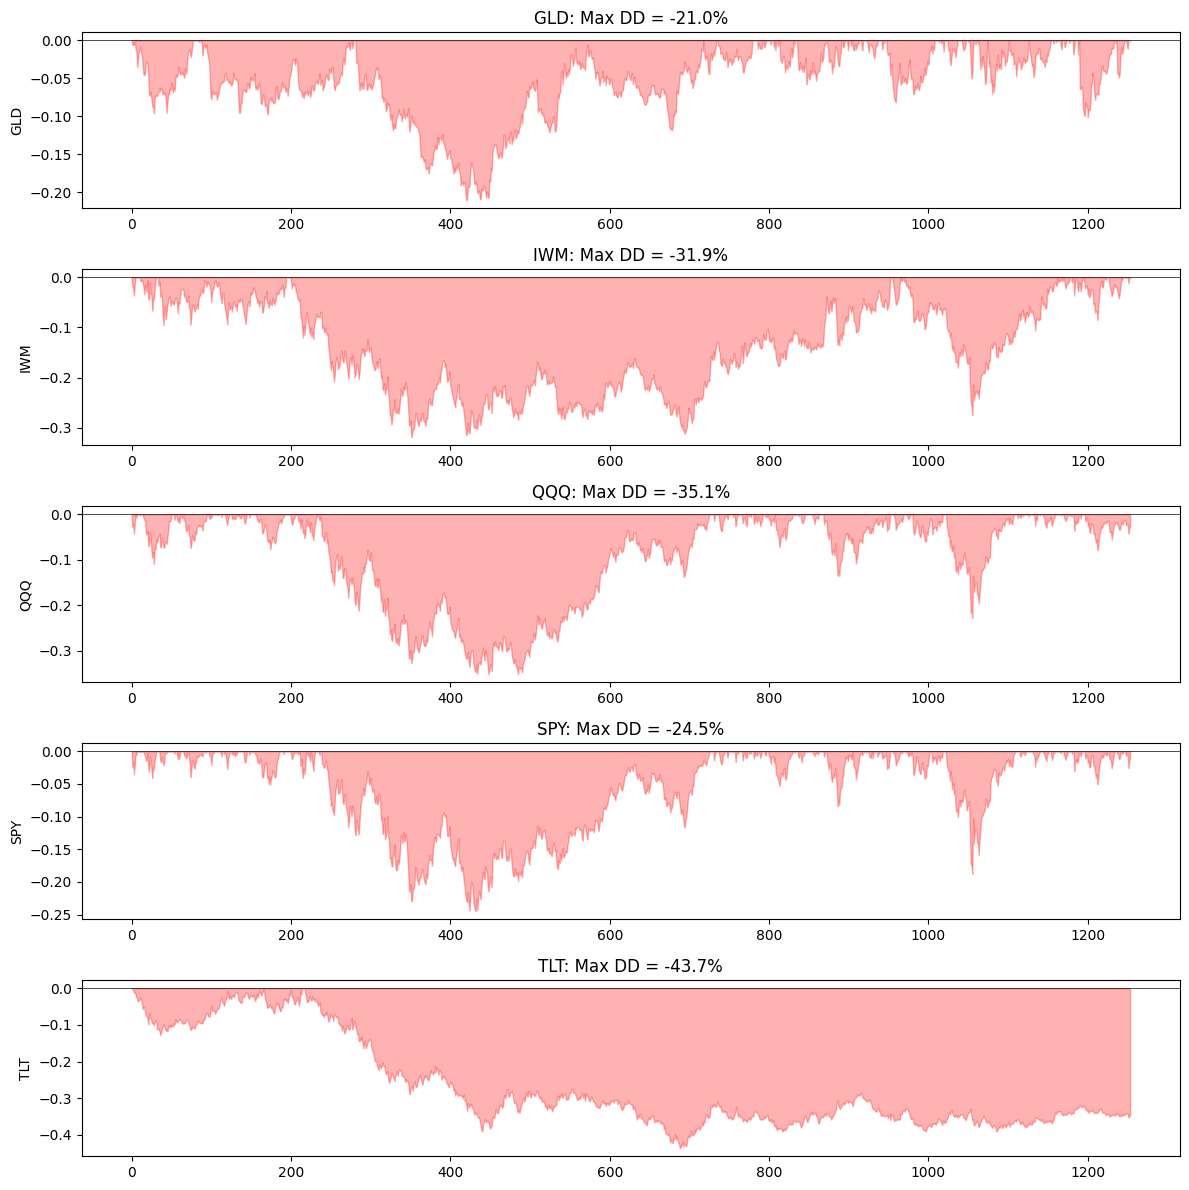

In [4]:
def max_drawdown_scratch(returns):
    """
    Calculate Maximum Drawdown and return drawdown series
    """
    # Cumulative returns (growth of $1)
    cumulative = (1 + pd.Series(returns)).cumprod()
    
    # Running peak
    running_peak = cumulative.expanding().max()
    
    # Drawdown at each point
    drawdown = (cumulative - running_peak) / running_peak
    
    # Maximum drawdown
    max_dd = drawdown.min()
    
    # Duration analysis
    underwater = drawdown < 0
    
    return max_dd, drawdown, cumulative

# Analyze all assets
print("📊 MAXIMUM DRAWDOWN ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(len(returns.columns), 1, figsize=(12, 12))

for i, ticker in enumerate(returns.columns):
    max_dd, dd_series, cum_series = max_drawdown_scratch(returns[ticker].values)
    
    axes[i].fill_between(range(len(dd_series)), dd_series.values, 0, 
                          color='red', alpha=0.3)
    axes[i].set_ylabel(ticker)
    axes[i].set_title(f'{ticker}: Max DD = {max_dd:.1%}')
    axes[i].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
print(f"{'Asset':<10} {'Max DD':<12} {'Total Return':<12}")
print("-" * 40)
for ticker in returns.columns:
    max_dd, _, cum = max_drawdown_scratch(returns[ticker].values)
    total_ret = cum.iloc[-1] - 1
    print(f"{ticker:<10} {max_dd:<12.1%} {total_ret:<12.1%}")

plt.tight_layout()
plt.show()

## 5. Comprehensive Metrics Dashboard

In [5]:
def calculate_all_metrics(returns):
    """Calculate comprehensive performance metrics"""
    returns = pd.Series(returns).dropna()
    
    # Returns
    total_ret = (1 + returns).prod() - 1
    n_years = len(returns) / 252
    annual_ret = (1 + total_ret) ** (1/n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    
    # Risk metrics
    sharpe = sharpe_ratio_scratch(returns.values)
    sortino = sortino_ratio_scratch(returns.values)
    max_dd, _, _ = max_drawdown_scratch(returns.values)
    calmar = annual_ret / abs(max_dd) if max_dd != 0 else 0
    
    # Trading metrics
    win_rate = (returns > 0).sum() / len(returns)
    avg_win = returns[returns > 0].mean() if (returns > 0).any() else 0
    avg_loss = abs(returns[returns < 0].mean()) if (returns < 0).any() else 0
    win_loss_ratio = avg_win / avg_loss if avg_loss > 0 else 0
    
    return {
        'Annual Return': annual_ret,
        'Annual Vol': annual_vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max Drawdown': max_dd,
        'Calmar': calmar,
        'Win Rate': win_rate,
        'Win/Loss Ratio': win_loss_ratio
    }

# Create metrics table
metrics_table = pd.DataFrame()
for ticker in returns.columns:
    metrics = calculate_all_metrics(returns[ticker].values)
    metrics_table[ticker] = pd.Series(metrics)

# Format display
print("📊 COMPREHENSIVE METRICS DASHBOARD")
print("=" * 80)
print(metrics_table.round(3).to_string())

📊 COMPREHENSIVE METRICS DASHBOARD
                  GLD    IWM    QQQ    SPY    TLT
Annual Return   0.208  0.060  0.143  0.140 -0.079
Annual Vol      0.157  0.228  0.226  0.171  0.160
Sharpe          1.283  0.371  0.702  0.849 -0.432
Sortino         1.285  0.374  0.678  0.829 -0.428
Max Drawdown   -0.210 -0.319 -0.351 -0.245 -0.437
Calmar          0.988  0.189  0.406  0.570 -0.180
Win Rate        0.541  0.515  0.548  0.545  0.490
Win/Loss Ratio  1.054  1.000  0.931  0.967  0.964


## 6. ⏱️ TIMED CODING CHALLENGE (30 minutes)

**Challenge:** Implement a function that:
1. Takes a series of returns
2. Calculates rolling Sharpe ratio (63-day window)
3. Identifies periods of high/low performance
4. Returns visualization and summary stats

In [6]:
# YOUR CODE HERE
def rolling_performance_analysis(returns, window=63):
    """
    Analyze rolling performance
    
    Returns:
    - Rolling Sharpe series
    - High/low performance periods
    - Visualization
    """
    # TODO: Implement rolling Sharpe
    
    # TODO: Identify high (>1) and low (<0) Sharpe periods
    
    # TODO: Create visualization
    
    pass

# Test your implementation
# rolling_performance_analysis(returns['SPY'].values)

## 7. Interview Question of the Day

**Q: What are the limitations of Sharpe Ratio?**

Think about:
1. Distribution assumptions
2. Time period sensitivity
3. Manipulation potential
4. Alternative metrics

In [7]:
# Demonstrate Sharpe limitations
print("📊 SHARPE RATIO LIMITATIONS DEMONSTRATION")
print("=" * 60)

# 1. Sensitivity to measurement period
spy_ret = returns['SPY']
periods = [63, 126, 252, 504, len(spy_ret)]
period_names = ['3 months', '6 months', '1 year', '2 years', 'Full period']

print("\n1. TIME PERIOD SENSITIVITY:")
for p, name in zip(periods, period_names):
    sharpe = sharpe_ratio_scratch(spy_ret.values[-p:])
    print(f"   {name:15}: Sharpe = {sharpe:.2f}")

# 2. Normal distribution assumption
from scipy import stats
skew = stats.skew(spy_ret)
kurt = stats.kurtosis(spy_ret)
print(f"\n2. NON-NORMAL RETURNS:")
print(f"   SPY Skewness: {skew:.2f} (normal = 0)")
print(f"   SPY Kurtosis: {kurt:.2f} (normal = 0)")

# 3. Manipulation example
print("\n3. SHARPE CAN BE GAMED:")
print("   Selling deep OTM puts → high Sharpe until blow-up!")

📊 SHARPE RATIO LIMITATIONS DEMONSTRATION

1. TIME PERIOD SENSITIVITY:
   3 months       : Sharpe = 0.97
   6 months       : Sharpe = 1.59
   1 year         : Sharpe = 0.84
   2 years        : Sharpe = 1.28
   Full period    : Sharpe = 0.85

2. NON-NORMAL RETURNS:
   SPY Skewness: 0.29 (normal = 0)
   SPY Kurtosis: 9.11 (normal = 0)

3. SHARPE CAN BE GAMED:
   Selling deep OTM puts → high Sharpe until blow-up!


## 8. Key Takeaways

| Metric | Best For | Limitation |
|--------|----------|------------|
| Sharpe | General comparison | Assumes normal returns |
| Sortino | Asymmetric strategies | Less known/used |
| Max DD | Risk management | Backward looking |
| Calmar | Long-term evaluation | Needs long history |

---

**Tomorrow:** Transaction Costs & Break-Even Analysis